In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
import sklearn

%matplotlib inline 

In [3]:
# find out package version 
print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'seaborn: {sns.__version__}')
print(f'sklearn: {sklearn.__version__}')

pandas: 1.1.5
numpy: 1.19.5
seaborn: 0.9.0
sklearn: 0.21.3


## Reading and inspecting the data
- For simplicity reason, I will use level one tick data
- Assuming the cost (y) is Avg_Bid_Ask_Spread is the cost of selling a security

In [4]:
file_path = os.getcwd()
df_tick_1 = pd.read_csv(os.path.join(file_path, 'ABC_Level_One_Tick_Data.csv'))
df_tick_1['Time_Hour'] = pd.to_datetime(df_tick_1['Time_Hour'])
df_tick_1['MinTimeHour'] = pd.to_datetime(df_tick_1['MinTimeHour'])
df_tick_1['MaxTimeHour'] = pd.to_datetime(df_tick_1['MaxTimeHour'])
df_tick_1['Time_duration'] = df_tick_1['MaxTimeHour'] - df_tick_1['MinTimeHour']
df_tick_1['Time_duration'] = df_tick_1['Time_duration'].dt.total_seconds()
df_tick_1['Month'] = df_tick_1['Time_Hour'].dt.month
df_tick_1['Day'] = df_tick_1['Time_Hour'].dt.day

In [5]:
df_tick_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Time_Hour           1023 non-null   datetime64[ns, UTC]
 1   Instrument_Code     1023 non-null   object             
 2   Open                1023 non-null   float64            
 3   High                1023 non-null   float64            
 4   Low                 1023 non-null   float64            
 5   Close               1023 non-null   float64            
 6   VWAP                1023 non-null   float64            
 7   TWAP                1023 non-null   float64            
 8   NumberOfTrades      1023 non-null   int64              
 9   Volume              1023 non-null   float64            
 10  Turnover            1023 non-null   float64            
 11  MinTimeHour         1023 non-null   datetime64[ns, UTC]
 12  MaxTimeHour         1023 non-null 

In [6]:
df_tick_1.describe()

,Open,High,Low,Close,VWAP,TWAP,NumberOfTrades,Volume,Turnover,Avg_Bid_Ask_Spread,Time_duration,Month,Day
count,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1.023000e+03,1.023000e+03,1023.000000,1023.000000,1023.000000,1023.000000
mean,44.006158,44.237205,43.773590,44.003787,44.014833,44.000656,3476.335288,3.947106e+05,2.054690e+09,-0.008525,3405.682526,3.277615,15.194526
std,7.045234,7.066492,7.152791,7.043902,7.053277,7.042722,3215.359465,4.901335e+05,2.600115e+09,0.157476,553.770279,1.589212,8.731945
min,33.636364,33.785909,6.339418,33.631818,33.647405,33.658734,1.000000,4.454545e+00,2.695991e+04,-0.945191,0.000000,1.000000,1.000000
25%,37.102273,37.268182,36.956818,37.131818,37.116435,37.113900,1379.000000,1.127750e+05,5.820509e+08,0.000469,3565.947508,2.000000,8.000000
50%,43.536364,43.968182,43.263636,43.595455,43.639305,43.640611,2487.000000,2.155232e+05,1.088315e+09,0.009007,3590.581415,3.000000,15.000000
75%,51.326005,51.509363,51.154545,51.295455,51.294998,51.269325,4414.500000,4.635416e+05,2.438367e+09,0.011248,3596.709406,5.000000,23.000000
max,54.354545,67.363636,54.336364,54.381818,56.555639,54.385951,24857.000000,4.424551e+06,2.483121e+10,1.941967,3599.929669,6.000000,31.000000


- chosing VWAP as cost and do auto regression transformer on it.
- have volume and time_duration as the model suggested in the word document

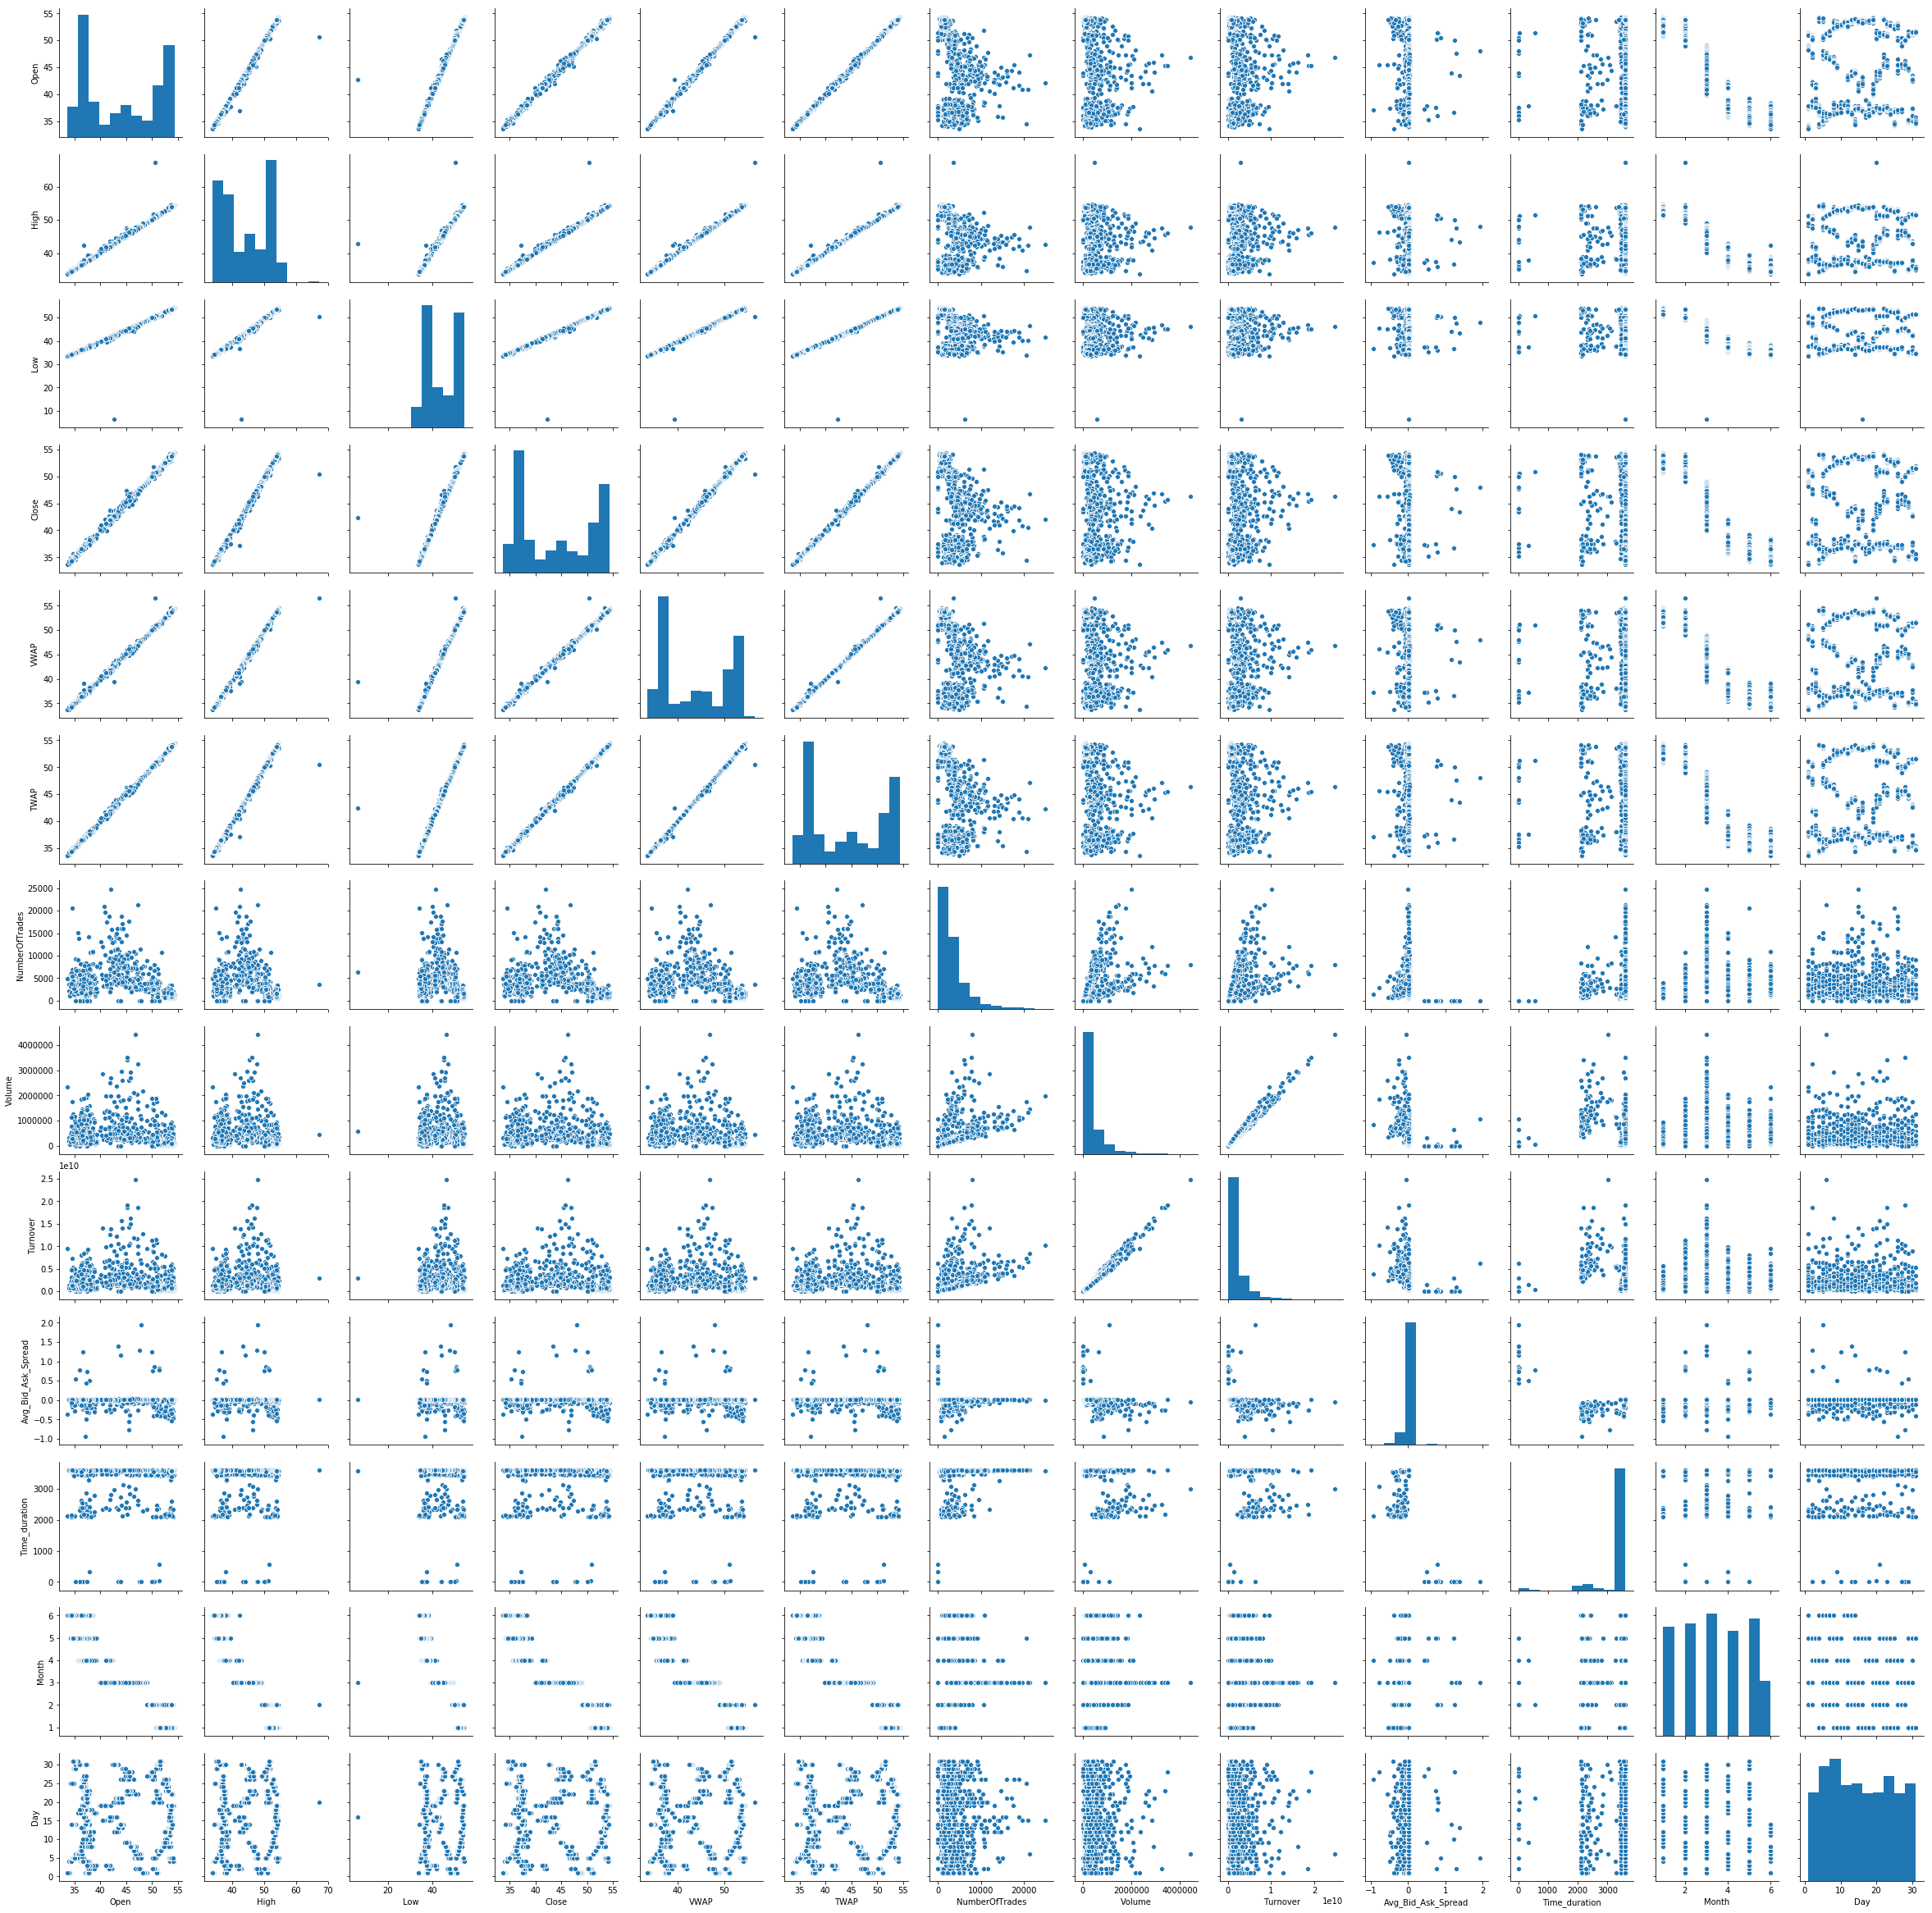

In [7]:
# pair plot
sns.pairplot(df_tick_1)

In [8]:
# look at the correlation
df_tick_1.corr()

,Open,High,Low,Close,VWAP,TWAP,NumberOfTrades,Volume,Turnover,Avg_Bid_Ask_Spread,Time_duration,Month,Day
Open,1.000000,0.996378,0.986945,0.999157,0.999164,0.999728,-0.225635,-0.112790,-0.018944,-0.028643,0.004611,-0.940178,0.042403
High,0.996378,1.000000,0.983536,0.996336,0.998313,0.996562,-0.210282,-0.096463,-0.002736,-0.032457,0.007773,-0.937209,0.045160
Low,0.986945,0.983536,1.000000,0.987117,0.988889,0.987376,-0.240800,-0.119678,-0.027061,-0.028260,0.000435,-0.925842,0.040653
Close,0.999157,0.996336,0.987117,1.000000,0.999124,0.999644,-0.226970,-0.107419,-0.013667,-0.033356,0.003636,-0.940045,0.043613
VWAP,0.999164,0.998313,0.988889,0.999124,1.000000,0.999430,-0.225943,-0.107949,-0.014054,-0.030709,0.004368,-0.939317,0.043868
TWAP,0.999728,0.996562,0.987376,0.999644,0.999430,1.000000,-0.226600,-0.112111,-0.018302,-0.029438,0.004359,-0.940235,0.043021
NumberOfTrades,-0.225635,-0.210282,-0.240800,-0.226970,-0.225943,-0.226600,1.000000,0.490430,0.466134,-0.056127,0.151173,0.167216,0.031738
Volume,-0.112790,-0.096463,-0.119678,-0.107419,-0.107949,-0.112111,0.490430,1.000000,0.989138,-0.312125,-0.306406,0.091529,0.001866
Turnover,-0.018944,-0.002736,-0.027061,-0.013667,-0.014054,-0.018302,0.466134,0.989138,1.000000,-0.316233,-0.299102,0.005793,0.013252
Avg_Bid_Ask_Spread,-0.028643,-0.032457,-0.028260,-0.033356,-0.030709,-0.029438,-0.056127,-0.312125,-0.316233,1.000000,-0.261707,0.036614,-0.030901


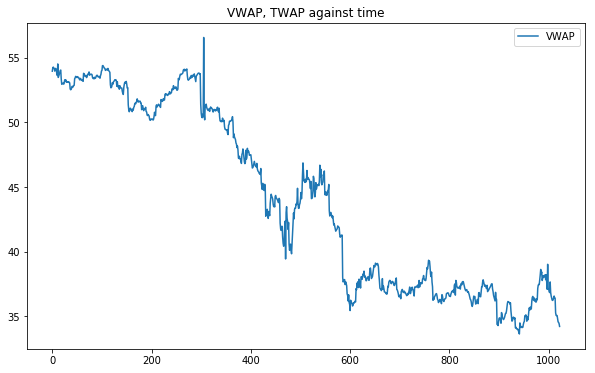

In [9]:
## VWAP and TWAP
df2 = df_tick_1[['VWAP']]

df2.plot(figsize=(10, 6), title= 'VWAP, TWAP against time')

- From the above charts, we can see that there are some spikes in late Feburary, mid March
- In this case, I will impute these outliers.

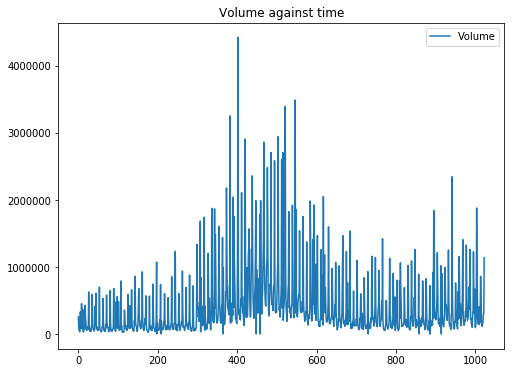

In [10]:
## Volume 
df2 = df_tick_1[['Volume']]
df2.plot(figsize=(8, 6), title= 'Volume against time')

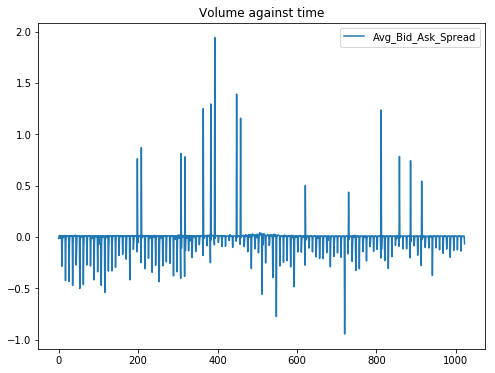

In [11]:
## Avg_Bid_Ask_Spread 
df3 = df_tick_1[['Avg_Bid_Ask_Spread']]
df3.plot(figsize=(8, 6), title= 'Volume against time')

In [12]:
# outlier inputation
inpute1 = df_tick_1['High'].max()
inpute2 = df_tick_1['Low'].min()
df_tick_2 = df_tick_1.copy()

df_tick_2.loc[df_tick_2['High'] == inpute1, 'High'] = np.nan
df_tick_2.loc[df_tick_2['Low'] == inpute2, 'Low'] = np.nan


df_tick_2['High'] = df_tick_2['High'].fillna(method = 'backfill')
df_tick_2['Low'] = df_tick_2['Low'].fillna(method = 'backfill')

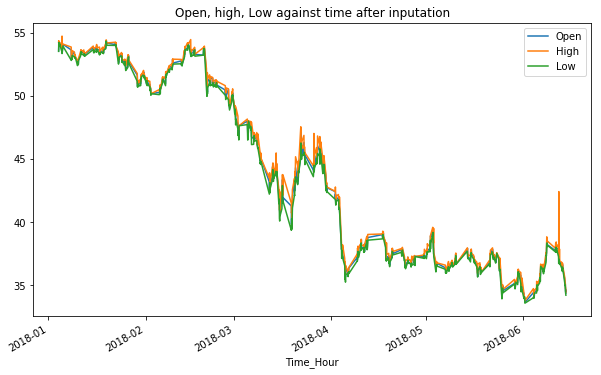

In [13]:
# check the  'Open', 'High','Low' 
df4 = df_tick_2[['Time_Hour', 'Open', 'High','Low']]
df4 = df4.set_index('Time_Hour')
df4.plot(figsize=(10, 6), title= 'Open, high, Low against time after inputation')

## Train test split

In [14]:
df_tick_2 = shuffle(df_tick_2)
X = df_tick_2.drop(['Time_Hour', 'Avg_Bid_Ask_Spread', 'Instrument_Code', 
                   'MinTimeHour', 'MaxTimeHour'], axis =1)
y = df_tick_2['Avg_Bid_Ask_Spread']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12, test_size = 0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(818, 12)
(818,)
(205, 12)
(205,)


## Random Forst regression

In [16]:
rfr = RandomForestRegressor(max_depth=4, random_state=12, n_jobs=-1)
rfr.fit(X_train, y_train)

/Users/kunsitu/anaconda2/envs/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=12, verbose=0,
                      warm_start=False)

In [17]:
cross_val_score(rfr, X_train, y_train, cv = 5, scoring='r2')

array([0.84819448, 0.87416028, 0.65330199, 0.77168585, 0.69787692])

In [18]:
y_predict = rfr.predict(X_test)
mse = mean_squared_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)
print(f'The mean squared error is: {mse}')
print(f'The R2 is : {r2}')

The mean squared error is: 0.0015462045652195442
The R2 is : 0.8366348908053922


In [19]:
feature_name = X.columns
importance = rfr.feature_importances_
for a,b in zip(feature_name, importance):
    print(f'{a}: {b:.4f}')

Open: 0.0018
High: 0.0029
Low: 0.0060
Close: 0.0073
VWAP: 0.0006
TWAP: 0.0018
NumberOfTrades: 0.1614
Volume: 0.0179
Turnover: 0.0519
Time_duration: 0.7193
Month: 0.0041
Day: 0.0251


Text(0.5,1,'predicted value vs true value against time')

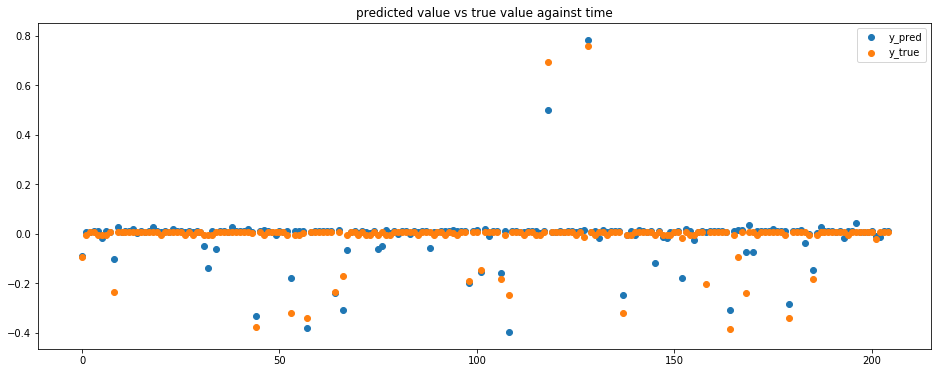

In [20]:
plt.figure(figsize=(16, 6))
time = [i for i in range(len(y_test))]
plt.scatter(x=time,  y = y_test)
plt.scatter(x=time,  y = y_predict)
plt.legend([ 'y_pred', 'y_true'])
plt.title('predicted value vs true value against time')

## Grid search to select the best parameters

In [21]:
param = {'max_depth': [2, 3, 4, 5, 6],
         'min_samples_leaf': [1, 2, 3],
         'min_samples_split': [2, 3, 4, 5, 6]
}

GSV = GridSearchCV(estimator=rfr, param_grid =param )
GSV.fit(X_train, y_train)

/Users/kunsitu/anaconda2/envs/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/kunsitu/anaconda2/envs/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=4, max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=-1,
                                             oob_score=False, random_state=12,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 

In [22]:
GSV.best_params_

{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}

## rerun the model with the best hyper parameters

In [23]:
rfr2 = RandomForestRegressor(max_depth=6, min_samples_leaf = 1, 
                             min_samples_split=2 ,random_state=12, n_jobs=-1)
rfr2.fit(X_train, y_train)
y_predict2 = rfr2.predict(X_test)
mse2 = mean_squared_error(y_test, y_predict)
r22 = r2_score(y_test, y_predict)
print(f'The mean squared error is: {mse}')
print(f'The R2 is : {r2}')

/Users/kunsitu/anaconda2/envs/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The mean squared error is: 0.0015462045652195442
The R2 is : 0.8366348908053922
